# Develop an initial model

In [1]:
# Python modules
import dateutil
from datetime import datetime
import re

# Data science packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit Learn utility classes & functions
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

# Scikit Learn models
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor

# Our own code
from src.data.preprocessing import betting_model_df, team_betting_model_df, cum_team_df
from src.model.metrics import measure_estimators, regression_accuracy

np.random.seed(42)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Set up data and create cumulative features

model_df = betting_model_df()
team_df = team_betting_model_df(model_df)
cum_df = cum_team_df(team_df)
cum_df

team         oppo_team  score  \
team             year round_number                                              
Adelaide         2010 2                     Adelaide            Sydney   75.0   
                      3                     Adelaide         Melbourne   41.0   
                      4                     Adelaide           Carlton   55.0   
                      5                     Adelaide  Western Bulldogs   72.0   
                      6                     Adelaide     Port Adelaide   74.0   
                      7                     Adelaide          Richmond  104.0   
                      8                     Adelaide   North Melbourne   75.0   
                      9                     Adelaide          Brisbane   93.0   
                      10                    Adelaide          St Kilda   76.0   
                      11                    Adelaide         Fremantle  105.0   
                      12                    Adelaide          Hawthorn   77.0   
                      13                    Adelaide         Melbourne  117.0   
                      14                    Adelaide          Essendon  124.0   
                      15                    Adelaide        West Coast  117.0   
                      16                    Adelaide           Geelong   74.0   
                      17                    Adelaide     Port Adelaide   69.0   
                      18                    Adelaide          Richmond   80.0   
                      19                    Adelaide  Western Bulldogs   53.0   
                      20                    Adelaide          Brisbane  104.0   
                      21                    Adelaide       Collingwood   51.0   
                      22                    Adelaide          St Kilda   65.0   
                 2011 1                     Adelaide          Hawthorn  105.0   
                      3                     Adelaide         Fremantle   54.0   
                      4                     Adelaide     Port Adelaide   66.0   
                      5                     Adelaide           Carlton   79.0   
                      6                     Adelaide          St Kilda   90.0   
                      7                     Adelaide         Melbourne   53.0   
                      8                     Adelaide        Gold Coast  130.0   
                      9                     Adelaide       Collingwood   92.0   
                      10                    Adelaide          Brisbane   61.0   
...                                              ...               ...    ...   
Western Bulldogs 2015 21            Western Bulldogs        West Coast   85.0   
                      22            Western Bulldogs   North Melbourne   96.0   
                      23            Western Bulldogs          Brisbane  122.0   
                      25            Western Bulldogs          Adelaide  102.0   
                 2016 1             Western Bulldogs         Fremantle  103.0   
                      2             Western Bulldogs          St Kilda   93.0   
                      3             Western Bulldogs          Hawthorn   90.0   
                      4             Western Bulldogs           Carlton   85.0   
                      5             Western Bulldogs          Brisbane  120.0   
                      6             Western Bulldogs   North Melbourne   45.0   
                      7             Western Bulldogs          Adelaide  123.0   
                      8             Western Bulldogs         Melbourne  114.0   
                      9             Western Bulldogs               GWS   73.0   
                      10            Western Bulldogs       Collingwood   74.0   
                      11            Western Bulldogs        West Coast   83.0   
                      12            Western Bulldogs     Port Adelaide  100.0   
                      13            Western Bulldogs           Geelong   43.0  

## Which models perform better on betting/match data?

In [3]:
# Set up & split data for models

team_features = pd.get_dummies(cum_df.drop(['score', 'oppo_score'], axis=1))
team_labels = pd.Series(cum_df['score'] - cum_df['oppo_score'], name='score_diff')
data = train_test_split(team_features, team_labels)

In [4]:
# Pass data to models & measure performance

linear = (Lasso(), ElasticNet(), Ridge(), LinearSVR())
print('LINEAR')
linear_scores = measure_estimators(linear, data, model_type='regression')

ensemble = (AdaBoostRegressor(),
            BaggingRegressor(),
            ExtraTreesRegressor(),
            GradientBoostingRegressor(),
            RandomForestRegressor(),
            SVR(kernel='rbf'),
            XGBRegressor())
print('\n\nENSEMBLE')
ensemble_scores = measure_estimators(ensemble, data, model_type='regression')

LINEAR


Lasso
Mean CV accuracy: 0.721878623453524
Test accuracy: 0.7197724039829303

Mean CV negative error score: 28.92482808337245
Test error score: 28.668881266323872


ElasticNet
Mean CV accuracy: 0.7223570600353479
Test accuracy: 0.7283072546230441

Mean CV negative error score: 29.199328672195584
Test error score: 28.930484991823935


Ridge
Mean CV accuracy: 0.7152322950321397
Test accuracy: 0.7283072546230441

Mean CV negative error score: 29.34157329224937
Test error score: 28.75721669321899


LinearSVR
Mean CV accuracy: 0.7104963357386497
Test accuracy: 0.7354196301564723

Mean CV negative error score: 29.44064488780206
Test error score: 28.938842058774075


ENSEMBLE


AdaBoostRegressor
Mean CV accuracy: 0.7152379236978083
Test accuracy: 0.7211948790896159

Mean CV negative error score: 29.34461551122855
Test error score: 29.18474113852738


BaggingRegressor
Mean CV accuracy: 0.703358061937837
Test accuracy: 0.7083926031294452

Mean CV negative error score: 30.997441884026973

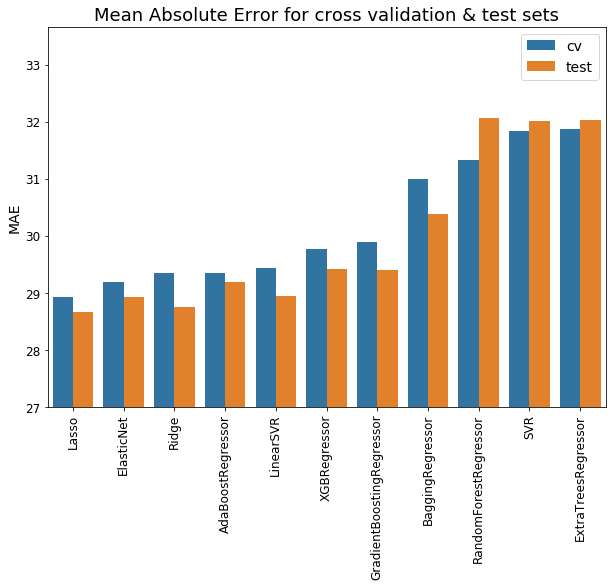

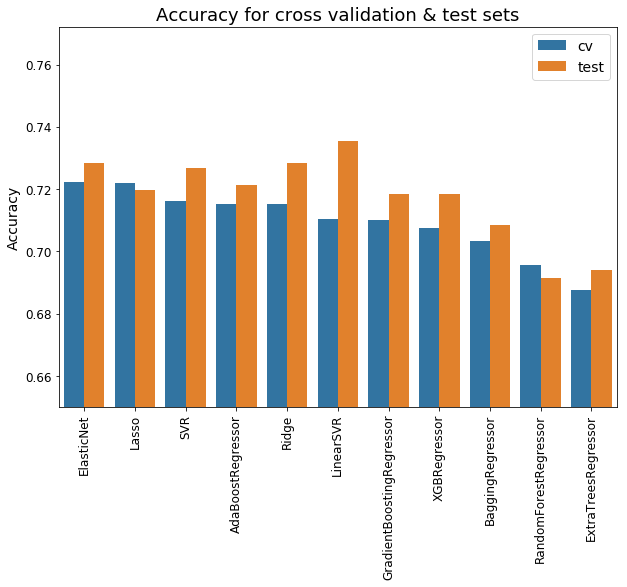

In [5]:
# MAE scores
mae_scores = linear_scores.append(ensemble_scores).sort_values(['score_type', 'error'], ascending=[True, True])

plt.figure(figsize=(10, 7))
sns.barplot(x='estimator', y='error', hue='score_type', data=mae_scores)
plt.ylim(ymin=27)
plt.title('Mean Absolute Error for cross validation & test sets', fontsize=18)
plt.ylabel('MAE', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

# Accuracy scores
acc_scores = linear_scores.append(ensemble_scores).sort_values(['score_type', 'accuracy'], ascending=[True, False])

plt.figure(figsize=(10, 7))
sns.barplot(x='estimator', y='accuracy', hue='score_type', data=acc_scores)
plt.ylim(ymin=0.65)
plt.title('Accuracy for cross validation & test sets', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

### Linear models perform better than ensembles

The 'boost' ensembles have comparable performance to the better linear models, but all the linear models get around 29 MAE for both the CV and test scores, with Lasso having the best error scores, ElasticNet the best CV accuracy, and LinearSVR the best test accuracy. Overall, Lasso seems to be the best model for this set of data.

## Does reducing the number of features make a difference?

In [6]:
# Try a stripped-down set of features to see if certain models are over-fitting and perform better with fewer features
# relative to other models

min_features = pd.get_dummies(cum_df[['team', 'oppo_team', 'line_odds', 'year', 'round_number', 'at_home']])

X_train, X_test = data[:2]
train_index = X_train.index
test_index = X_test.index

min_data = (min_features.loc[train_index, :],
            min_features.loc[test_index, :],
            data[2],
            data[3])

print('LINEAR')
min_linear_scores = measure_estimators(linear, min_data, model_type='regression')
print('\n\nENSEMBLE')
min_ensemble_scores = measure_estimators(ensemble, min_data, model_type='regression')

LINEAR


Lasso
Mean CV accuracy: 0.7233026758676588
Test accuracy: 0.7197724039829303

Mean CV negative error score: 28.844179688181413
Test error score: 28.663032589757844


ElasticNet
Mean CV accuracy: 0.7237777352500816
Test accuracy: 0.7254623044096729

Mean CV negative error score: 29.83222884116024
Test error score: 30.159793716781024


Ridge
Mean CV accuracy: 0.7161801623307179
Test accuracy: 0.7211948790896159

Mean CV negative error score: 29.086308415750885
Test error score: 28.846702250629168


LinearSVR
Mean CV accuracy: 0.7104907070729812
Test accuracy: 0.7268847795163584

Mean CV negative error score: 29.199691937057548
Test error score: 29.141499494608503


ENSEMBLE


AdaBoostRegressor
Mean CV accuracy: 0.7223536828359469
Test accuracy: 0.7240398293029872

Mean CV negative error score: 29.391422946089257
Test error score: 29.024322353243353


BaggingRegressor
Mean CV accuracy: 0.6886593644110728
Test accuracy: 0.6941678520625889

Mean CV negative error score: 32.53454424

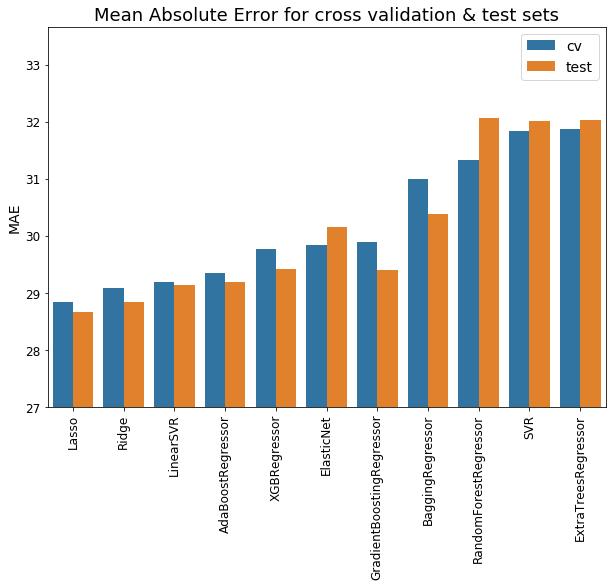

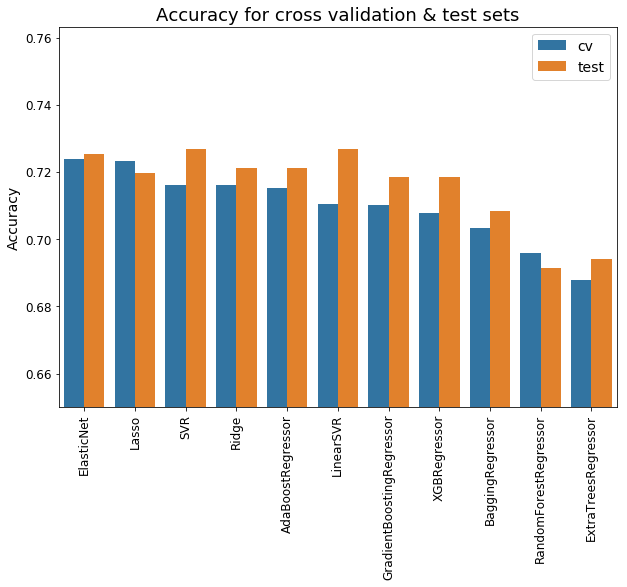

In [7]:
# MAE scores
mae_scores = min_linear_scores.append(ensemble_scores).sort_values(['score_type', 'error'], ascending=[True, True])

plt.figure(figsize=(10, 7))
sns.barplot(x='estimator', y='error', hue='score_type', data=mae_scores)
plt.ylim(ymin=27)
plt.title('Mean Absolute Error for cross validation & test sets', fontsize=18)
plt.ylabel('MAE', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

# Accuracy scores
acc_scores = min_linear_scores.append(ensemble_scores).sort_values(['score_type', 'accuracy'], ascending=[True, False])

plt.figure(figsize=(10, 7))
sns.barplot(x='estimator', y='accuracy', hue='score_type', data=acc_scores)
plt.ylim(ymin=0.65)
plt.title('Accuracy for cross validation & test sets', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

### Linear models are still the best

Even with fewer features to prevent the ensemble models from overfitting, the linear models tend to perform better, and Lasso is still best-performing.

## Is Lasso or ElastcNet better?

In [13]:
# Round 24 represents first finals round and doesn't count for tipping competitions
tipping_features = team_features[team_features['round_number'] < 24]
tipping_labels = team_labels[tipping_features.index.values]

lasso = make_pipeline(StandardScaler(), Lasso())
en = make_pipeline(StandardScaler(), ElasticNet())

estimators = (lasso, en)

model_names = []
errors = []
accuracies = []
years = []

for year in range(2011, 2017):
    X_train = tipping_features[tipping_features['year'] < year]
    X_test = tipping_features[tipping_features['year'] == year]
    y_train = tipping_labels.loc[X_train.index]
    y_test = tipping_labels.loc[X_test.index]
    
    for estimator in estimators:
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)

        years.append(year)
        model_names.append(estimator.steps[-1][0])
        errors.append(mean_absolute_error(y_test, y_pred))
        accuracies.append(regression_accuracy(y_test, y_pred))
        
year_scores = pd.DataFrame({'model': model_names,
                            'year': years,
                            'error': errors,
                            'accuracy': accuracies})
year_scores

,model,year,error,accuracy
0,lasso,2011,29.139495,0.747191
1,elasticnet,2011,29.695438,0.724719
2,lasso,2012,29.902437,0.751269
3,elasticnet,2012,29.913677,0.746193
4,lasso,2013,26.372270,0.734848
5,elasticnet,2013,26.631858,0.727273
6,lasso,2014,27.920279,0.712121
7,elasticnet,2014,28.806113,0.702020
8,lasso,2015,30.382857,0.718274
9,elasticnet,2015,30.647588,0.730964


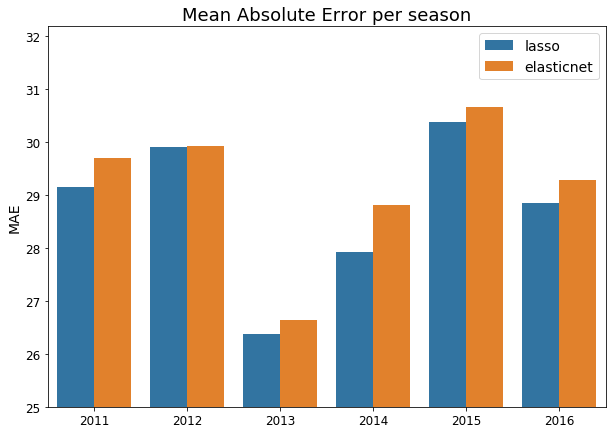

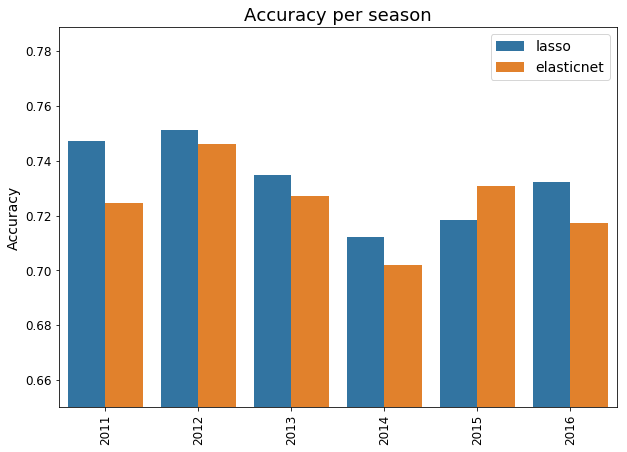

In [18]:
# MAE scores
plt.figure(figsize=(10, 7))
sns.barplot(x='year', y='error', hue='model', data=year_scores)
# Not starting axis at 0 to make small relative differences clearer
plt.ylim(ymin=25)
plt.title('Mean Absolute Error per season', fontsize=18)
plt.ylabel('MAE', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.legend(fontsize=14)

plt.show()

# Accuracy scores
plt.figure(figsize=(10, 7))
sns.barplot(x='year', y='accuracy', hue='model', data=year_scores)
# Not starting axis at 0 to make small relative differences clearer
plt.ylim(ymin=0.65)
plt.title('Accuracy per season', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

### Lasso is the best model

Although, ElasticNet has slightly higher accuracy for CV and test set, Lasso is more accurate for 5 of 6 seasons. Also, Lasso has a lower MAE for CV, test set, and all 6 test seasons.

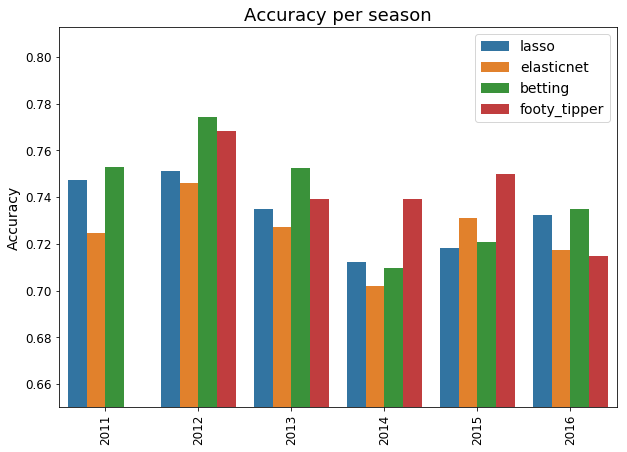

In [25]:
# Accuracy scores with betting accuracy & footy tipper

betting_scores = (((cum_df['line_odds'] < 0) & (cum_df['score'] >= cum_df['oppo_score']) |
                   (cum_df['line_odds'] > 0) & (cum_df['score'] <= cum_df['oppo_score']))
                  .loc[tipping_features[tipping_features['year'] > 2010].index.values]
                  .rename('accuracy')
                  .groupby(level=1)
                  .mean()
                  .reset_index()
                  .assign(model='betting', error=0))
# Footy tipper accuracy scores taken from a trial that took too long to run,
# so I'm just copy pasting from a notebook
footy_tipper_scores = pd.DataFrame({'model': ['footy_tipper'] * len(range(2012, 2017)),
                                    'year': list(range(2012, 2017)),
                                    'error': [0] * len(range(2012, 2017)),
                                    'accuracy': [0.768116, 0.739130, 0.739130, 0.750000, 0.714976]})

plt.figure(figsize=(10, 7))
sns.barplot(x='year',
            y='accuracy',
            hue='model',
            data=year_scores.append([betting_scores, footy_tipper_scores], sort=False))
# Not starting axis at 0 to make small relative differences clearer
plt.ylim(ymin=0.65)
plt.title('Accuracy per season', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

Even without any tuning, a lasso model performs reasonably well, beating the betting odds in one season (vs 2 for Footy Tipper) and beating the fully-tuned Footy Tipper ensemble 1 out of 5 times. Pretty good start.